Utility functions

In [226]:
import os
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create custom style dictionary
custom_style = {
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0
}

# Update seaborn's whitegrid style with your custom settings
sns.set_theme(style="whitegrid", rc=custom_style)
sns.set_context("paper", 
                font_scale=2.5,
                rc={
                    "lines.linewidth": 2,
                    "axes.grid": True,
                    "grid.alpha": 0.3,
                    "figure.figsize": (8.5, 6)
                })
from matplotlib import rc

rc('xtick.major', pad=10)
rc('ytick.major', pad=10)
rc('grid', linewidth=1.3)


In [272]:
import pickle

dataset = "c5m" # c5m or mlp

with open(f"../logs/{dataset}_schedules.pkl", "rb") as f:
    df = pickle.load(f)
df['P'] = df['num_params']
# sort by P
df = df.sort_values(["P", "decay_frac"])
df = df.sort_values(["schedule", "decay_frac", "D"])

# rename schedule
schedule_name = {
    'const': 'const',
    'linear': r'$1-x$',
    'cosine': r'$0.5(1+\cos(\pi x))$',
    'exp': r'$10^{-x}$', 
    'multicosine': r'$0.5(1+\cos(3\pi x))$', 
    'power': r'$(1-x)^2$',
    'quadratic': r'$1-x^2$',
}
df['schedule'] = df['schedule'].apply(lambda x: schedule_name[x])
# decay frac >= 0.1 or constant
df = df[(df['decay_frac'] >= 0.1) | (df['schedule'] == 'const')]
# merge decay_frac as percentage and schedule
df['schedule'] = df['schedule'] + df['decay_frac'].apply(lambda x: f" ({x * 100:.0f}%)" if 0 < x < 1 else "")

In [273]:
from scipy.interpolate import interp1d
cmap = sns.color_palette("plasma", as_cmap=True)
# Create dict of constant lr runs indexed by (D, B, lr)
const_lr_runs = {(row['D'], row['B'], row['lr']): row 
                for _, row in df[df['schedule'] == r'const'].iterrows()}

new_dfs = []
# Process each group of runs with same D, B, lr
for (D, B, lr), group_df in df.groupby(['D', 'B', 'lr']):
    if (D, B, lr) not in const_lr_runs:
        continue
        
    const_lr_run = const_lr_runs[(D, B, lr)]
    const_lr = const_lr_run['history']['lr'].max()
    loss_const_lr = const_lr_run['history']['test_loss']
    gvar_const_lr = np.array(const_lr_run['history']['Buvar']) # trace of mini-batch preconditoned gradient covariance
    tau_const_lr = np.array(const_lr_run['history']['tau'])
    # align loss and gradient noise curves based on tau (gradient flow time)
    f_const = interp1d(tau_const_lr, loss_const_lr, bounds_error=False)
    f_const_gvar = interp1d(tau_const_lr, gvar_const_lr, bounds_error=False)
    
    for _, run in group_df.iterrows():
        history = run['history']
        history['ds'] = (history['lr'] - const_lr) / const_lr # peak lr is absorbed into the preconditioner, so we keep only the schedule
        history['s'] = history['lr'] / const_lr
        history['orig_loss'] = f_const(history['tau'])
        history['orig_gvar'] = f_const_gvar(history['tau'])
        history['gvar'] = history['Buvar']
        new_dfs.append(run)
        schedule = run['schedule']
        decay_frac = run['decay_frac']


df = pd.DataFrame(new_dfs)
all_df = df

In [274]:
blue_600 = "#1a73e8"
red_600 = "#d93025"
orange_600 = "#e8710a"
purple_600 = "#9334e6"
cyan_700 = "#129eaf"
yellow_500 = "#fbbc04"
pink_600 = "#e52592"
green_700 = "#188038"

colors = [
    blue_600,    # Primary blue
    red_600,     # Rich red
    orange_600,  # High contrast orange
    purple_600,  # Purple
    cyan_700,    # Teal/cyan
    yellow_500,  # Bright yellow
    pink_600,    # Magenta/pink (instead of second purple)
    green_700,   # Medium green
]

def ema(x, y, halflife):
    if not halflife:
        return y
    x = np.array(x) / x.max()
    t = x[:, None]
    s = x[None, :]
    y = np.array(y)
    tau = halflife / np.log(2)
    w = np.exp(- (t - s) / tau) * (t > s) # (t, s)
    return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)

Configure plots and set $\alpha$

In [281]:
if dataset == "c5m":
    alpha = 0.21 
    ymin = [3.165, 3.155, 3.16]
    ymax = [3.205, 3.205, 3.205]
    D0, T0 = 1024, 10e9 # fig a
    Ds = [768, 1280, 2048] # fig b
    Ts = [2.5e9, 5e9, 10e9, 20e9] # fig c
elif dataset == "mlp":
    alpha = 0.26
    ymin = [0.022, 0.018, 0.021]
    ymax = [0.042, 0.05, 0.042]
    D0, T0 = 1024, 1e9 # fig b
    Ds = [512, 1024, 2048] # fig b
    Ts = [5e8, 1e9, 2e9] # fig c
else:
    print(f"Unknown dataset: {dataset}")

/tmp/ipykernel_1117906/1769073263.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)
/tmp/ipykernel_1117906/1769073263.py:30: RuntimeWarning: invalid value encountered in divide
  return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)


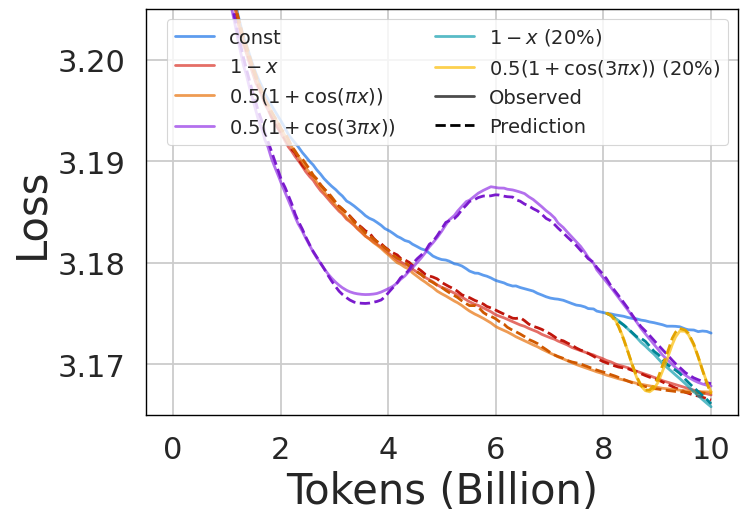

In [282]:

df = all_df[all_df['D'] == D0]
df = df[df['T'] == T0]
P = df['P'].iloc[0]
schedules = ['const', '$1-x$', '$0.5(1+\\cos(\\pi x))$', '$0.5(1+\\cos(3\\pi x))$', '$1-x$ (20%)',  '$0.5(1+\\cos(3\\pi x))$ (20%)']
df = df[df['schedule'].isin(schedules)]

halflife = 0.01

plt.figure(figsize=(8, 5.75), dpi=100)
for i, schedule in enumerate(schedules):
    try:
        row = df[df['schedule'] == schedule].iloc[0]
    except:
        continue
    t = np.array(row["history"]["tokens"])
    L = np.array(row["history"]["test_loss"])
    L_old = np.array(row["history"]["orig_loss"])
    gvar = np.array(row["history"]["gvar"])
    gvar_old = np.array(row["history"]["orig_gvar"])
    dgvar = gvar - gvar_old
    dlr = np.array(row["history"]["ds"])
    lr = np.array(row["history"]["s"])
    
    term1 = dlr * gvar
    term2 = 1 * dgvar
    term = term1

    L_pred = L_old + alpha * term

    # label = row["schedule"] + rf"\, $(\alpha = {alpha:.2f})$" if row["schedule"] != r'const' else row["schedule"]
    label = row["schedule"] if row["schedule"] != r'const' else row["schedule"]
    idx = np.linspace(0, len(t)-1, min(200, len(t))).astype(int)
    mask = np.zeros(len(t), dtype=bool)
    mask[idx] = True
    if schedule != 'const':
        done_warmup = (np.cumsum(lr >= 0.999) > 0)
        mask = mask & (np.cumsum(dlr * done_warmup < -0.01) > 0)
    
    # Use custom colors
    plt.plot(t[mask] / 1e9, ema(t, L, halflife)[mask], lw=2, label=label, ls='-', color=colors[i], alpha=0.7)
    if row["schedule"] != r'const':
        import matplotlib.colors as mcolors
        fit_color = mcolors.to_rgb(colors[i])
        fit_color = tuple(max(0, min(1, c - 0.1)) for c in fit_color)  # Lighter version
        plt.plot(t[mask] / 1e9, ema(t, L_pred, halflife)[mask], lw=2, ls='--', color=fit_color, alpha=1)

plt.xlabel("Tokens (Billion)", fontsize=30)
plt.ylabel("Loss", fontsize=30)
plt.ylim(ymin[0], ymax[0])

from matplotlib.ticker import MaxNLocator
ax = plt.gca()
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))

plt.tight_layout()
plt.plot([], [], lw=2, ls='-', color='black', alpha=0.7, label='Observed')
plt.plot([], [], lw=2, ls='--', color='black', alpha=1, label='Prediction')
plt.legend(fontsize=14, loc='upper right', ncol=2, framealpha=0.8)


/tmp/ipykernel_1117906/1769073263.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)
/tmp/ipykernel_1117906/1769073263.py:30: RuntimeWarning: invalid value encountered in divide
  return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)


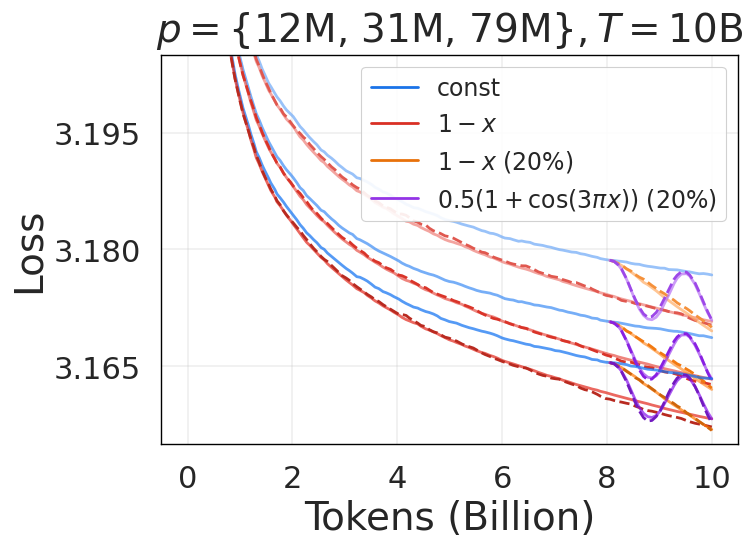

In [288]:
# Import color manipulation libraries once
import matplotlib.colors as mcolors
import colorsys
schedules = ['const', '$1-x$', '$1-x$ (20%)',  '$0.5(1+\\cos(3\\pi x))$ (20%)']


# Collect all P values first to determine color scaling
all_P_values = []
for D in Ds:
    df_temp = all_df[all_df['D'] == D]
    df_temp = df_temp[df_temp['T'] == T0]
    if len(df_temp) > 0:
        all_P_values.append(df_temp['P'].iloc[0])

# Normalize P values for color intensity
P_min, P_max = min(all_P_values), max(all_P_values)


plt.figure(figsize=(8, 6), dpi=100)
halflife = 0.01
# Plot for each D value
for d_idx, D in enumerate(Ds):
    df = all_df[all_df['D'] == D]
    df = df[df['T'] == T0]
    if len(df) == 0:
        continue
    
    P = df['P'].iloc[0]
    df = df[df['schedule'].isin(schedules)]
    
    # Calculate intensity based on P value using log scale
    if P_max > P_min:
        log_P = np.log10(P)
        log_P_min = np.log10(P_min)
        log_P_max = np.log10(P_max)
        intensity = (log_P - log_P_min) / (log_P_max - log_P_min)
    else:
        intensity = 0.5
    
    for i, schedule in enumerate(schedules):
        try:
            row = df[df['schedule'] == schedule].iloc[0]
        except:
            continue
        
        t = np.array(row["history"]["tokens"])
        L = np.array(row["history"]["test_loss"])
        L_old = np.array(row["history"]["orig_loss"])
        gvar = np.array(row["history"]["gvar"])
        gvar_old = np.array(row["history"]["orig_gvar"])
        dgvar = gvar - gvar_old
        dlr = np.array(row["history"]["ds"])
        lr = np.array(row["history"]["s"])
        
        term1 = dlr * gvar
        term = term1

        L_pred = L_old + alpha * term

        idx = np.linspace(0, len(t)-1, min(200, len(t))).astype(int)
        mask = np.zeros(len(t), dtype=bool)
        mask[idx] = True
        if schedule != 'const':
            done_warmup = (np.cumsum(lr >= 0.999) > 0)
            mask = mask & (np.cumsum(dlr * done_warmup < -0.01) > 0)
        
        # Adjust color based on P value - use saturation/lightness variation
        base_rgb = mcolors.to_rgb(colors[i])
        h, l, s = colorsys.rgb_to_hls(*base_rgb)
        
        # Adjust lightness based on intensity (lighter for smaller P)
        # Map intensity to lightness range 0.5 to 0.7 (keeping colors vibrant)
        new_l = 0.7 - 0.2 * intensity
        # Keep saturation high for vibrant colors
        new_s = min(1.0, s * 1.1)
        
        adjusted_color = colorsys.hls_to_rgb(h, new_l, new_s)
        
        # Create label only for the first D value
        if d_idx == 0:
            label = f'{schedule}'
        else:
            label = None
            
        # Plot actual data
        plt.plot(t[mask] / 1e9, ema(t, L, halflife)[mask], 
                lw=2, ls='-', color=adjusted_color, alpha=0.7)
        # empty data just for legend
        plt.plot([], [], lw=2, label=label, ls='-', color=colors[i])
        
        # Plot fitted line if not const
        if row["schedule"] != r'const':
            # Make fitted line slightly different - adjust saturation
            fit_l = new_l * 0.85  # Slightly darker
            fit_s = new_s * 0.9   # Slightly less saturated
            fit_color = colorsys.hls_to_rgb(h, fit_l, fit_s)
            plt.plot(t[mask] / 1e9, ema(t, L_pred, halflife)[mask], 
                    lw=2, ls='--', color=fit_color, alpha=1)

plt.xlabel("Tokens (Billion)", fontsize=28)
plt.ylabel("Loss", fontsize=28)
p_set_latex_str = r'${' + ', '.join([f'{p/1e6:.0f}M' for p in all_P_values]) + r'}$'
plt.title(rf"$p={p_set_latex_str}, T={T0/1e9:.0f}$B", fontsize=28, pad=10)
plt.ylim(ymin[1], ymax[1])
plt.legend(fontsize=17, loc='upper right', framealpha=0.9)
plt.grid(True, alpha=0.3)

from matplotlib.ticker import MaxNLocator
ax = plt.gca()
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))

plt.tight_layout()

/tmp/ipykernel_1117906/1769073263.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)
/tmp/ipykernel_1117906/1769073263.py:30: RuntimeWarning: invalid value encountered in divide
  return np.trapz(w * y, s, axis=1) / np.trapz(w, s, axis=1) # int ds w(t, s) y(s)


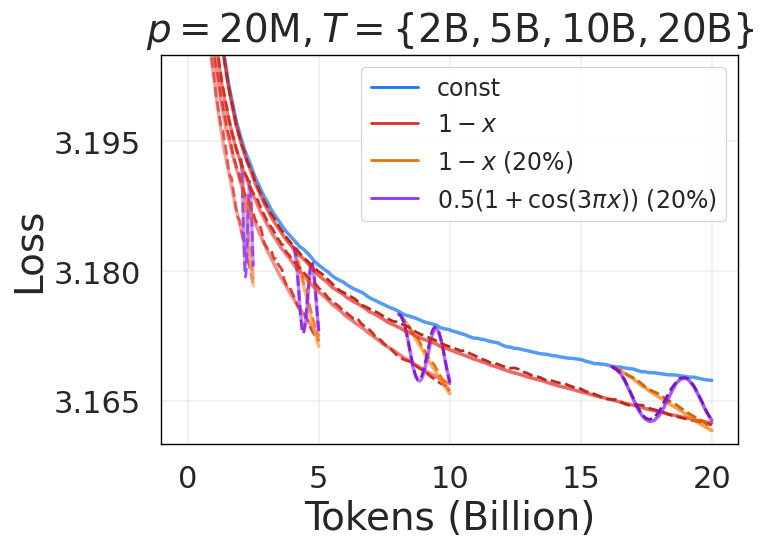

In [287]:
schedules = ['const', '$1-x$', '$1-x$ (20%)',  '$0.5(1+\\cos(3\\pi x))$ (20%)']


# Create single figure
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([], [], lw=2, label=r'const', ls='-', color=colors[0])
halflife = 0.01

# Normalize T values for color intensity
T_min, T_max = min(Ts), max(Ts)

# Plot for each T value
for t_idx, T in enumerate(Ts):
    df = all_df[all_df['D'] == D0]
    df = df[df['T'] == T]
    if len(df) == 0:
        continue
    
    P = df['P'].iloc[0]
    df = df[df['schedule'].isin(schedules)]
    
    # Calculate intensity based on T value using log scale
    if T_max > T_min:
        log_T = np.log10(T)
        log_T_min = np.log10(T_min)
        log_T_max = np.log10(T_max)
        intensity = (log_T - log_T_min) / (log_T_max - log_T_min)
    else:
        intensity = 0.5
    
    for i, schedule in enumerate(schedules):
        try:
            row = df[df['schedule'] == schedule].iloc[0]
        except:
            continue
        if row["schedule"] == r'const':
            # only plot max T
            if T != max(Ts):
                continue
            
        
        t = np.array(row["history"]["tokens"])
        L = np.array(row["history"]["test_loss"])
        L_old = np.array(row["history"]["orig_loss"])
        gvar = np.array(row["history"]["gvar"])
        gvar_old = np.array(row["history"]["orig_gvar"])
        dgvar = gvar - gvar_old
        dlr = np.array(row["history"]["ds"])
        lr = np.array(row["history"]["s"])
        
        L_pred = L_old + alpha * dlr * gvar

        idx = np.linspace(0, len(t)-1, min(200, len(t))).astype(int)
        mask = np.zeros(len(t), dtype=bool)
        mask[idx] = True
        if schedule != 'const':
            done_warmup = (np.cumsum(lr >= 0.999) > 0)
            mask = mask & (np.cumsum(dlr * done_warmup < -0.01) > 0)
        
        # Adjust color based on P value - use saturation/lightness variation
        base_rgb = mcolors.to_rgb(colors[i])
        h, l, s = colorsys.rgb_to_hls(*base_rgb)
        
        # Adjust lightness based on intensity (lighter for smaller P)
        # Map intensity to lightness range 0.5 to 0.7 (keeping colors vibrant)
        new_l = 0.7 - 0.2 * intensity
        # Keep saturation high for vibrant colors
        new_s = min(1.0, s * 1.1)
        
        adjusted_color = colorsys.hls_to_rgb(h, new_l, new_s)
        
        # Create label only for the first T value
        if t_idx == 0:
            label = f'{schedule}'
        else:
            label = None
            
        # Plot actual data
        plt.plot(t[mask] / 1e9, ema(t, L, halflife)[mask], 
                lw=2.5, ls='-', color=adjusted_color, alpha=0.7)
        plt.plot([], [], lw=2, label=label, ls='-', color=colors[i])
        
        # Plot fitted line if not const
        if row["schedule"] != r'const':
            # Make fitted line slightly different - adjust saturation
            fit_l = new_l * 0.85  # Slightly darker
            fit_s = new_s * 0.9   # Slightly less saturated
            fit_color = colorsys.hls_to_rgb(h, fit_l, fit_s)
            plt.plot(t[mask] / 1e9, ema(t, L_pred, halflife)[mask], 
                    lw=2, ls='--', color=fit_color, alpha=1)

plt.xlabel("Tokens (Billion)", fontsize=28)
plt.ylabel("Loss", fontsize=28)

# Create T set string for title
t_set_latex_str = r'\{' + ', '.join([rf'{T/1e9:.0f}' + r'\mathrm{B}' for T in Ts]) + r'\}'
plt.title(rf"$p={P/1e6:.0f}\mathrm{{M}}, T={t_set_latex_str}$", fontsize=28, pad=10)


# Adjust y-axis limits based on the range of data
plt.ylim(ymin[2], ymax[2])
plt.legend(fontsize=17, loc='upper right', framealpha=0.9)
plt.grid(True, alpha=0.3)

from matplotlib.ticker import MaxNLocator
ax = plt.gca()
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
plt.tight_layout()